### Kaggle Challenge: Real Disaster or Not?
website:https://www.kaggle.com/c/nlp-getting-started/overview/description

The task of this challenge is to determine if a tweet (normally a short sentence) announces a real disaster of not. A labelled corpus containing 6768 sentences is provided. 

The data is pre-processed and saved in cleaned_train.csv, as the testing set is leaky, the testing set is available as well (saved in perfect_test.csv), used to evaluate different models here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
from IPython.display import clear_output
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import time
import pickle
import util
import encoders
from util import Text2mat
from encoders import CombinedEncoder, WordRNN, CharRNN

import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)

2.1.0


##### read data

In [2]:
df_train = pd.read_csv('./data/cleaned_train.csv')
lines = df_train.text.values
y = df_train.target.values

df_test = pd.read_csv('./data/perfect_test.csv')
lines_test = df_test.text.values
y_test = df_test.target.values

lines_train, lines_dev, y_train, y_dev = train_test_split(lines,y,test_size=0.2,random_state=42)

##### baseline model: tfidf + naive bayes

In [3]:
not_real_prob = (y==0).sum()/len(y)
prior_probs = [not_real_prob,1-not_real_prob]

#optimal parameters found by cross-validation search within given parameter set
tfidf = TfidfVectorizer(stop_words='english',max_features=10000,max_df=0.8,ngram_range=(1,2))
nb = MultinomialNB(class_prior=prior_probs)

pipeline = Pipeline([('tfidf',tfidf),
                     ('clf',nb)])

pipeline.fit(lines,y)
print(sklearn.metrics.f1_score(y_test,pipeline.predict(lines_test)))

0.7114657706845863


##### neural method: wordRNN with pre-trained word embeddings (Glove)

In [7]:
#represent texts by vocabulary index matrixs
text2mat_word = Text2mat(lines,low_count_threshold=2)

#glove embeddings are pre-processed and saved in a .pkl file
with open('glove-wiki-gigaword-100-word-embeddings.pkl','rb') as f:
    pre_embeddings = pickle.load(f)

all_pre_embeddings = np.stack(pre_embeddings.values())
#generate random embedding for out-of-vocabulary word, centered at the center of all pre-trained embeddings.
pre_embed_mean, pre_embed_var = np.mean(all_pre_embeddings,axis=0), np.var(all_pre_embeddings,axis=0)

embedding_weight_matrix = np.random.normal(pre_embed_mean,pre_embed_var,(text2mat_word.n_tokens,100))
for i in range(text2mat_word.n_tokens):
    word = text2mat_word.id_to_token[i]
    if word in pre_embeddings:
        embedding_weight_matrix[i] = pre_embeddings[word]
        
emb_size, hid_size = 100, 64
vocab_size = text2mat_word.n_tokens

model = WordRNN(vocab_size,emb_size,hid_size,pre_trained_weights=embedding_weight_matrix,emb_trainable=False)

##### training

In [8]:
def compute_loss(model,batch_lines,batch_label):
    logits = model.get_logits(batch_lines,text2mat_word)
    labels = tf.cast(tf.reshape(batch_label,[-1,1]),logits.dtype)
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels,logits))

def validation_loss(model,dev_lines,dev_label,batch_size=64):
    total_loss = 0
    N = len(dev_lines)
    step = 0
    for i in range(0,N,batch_size):
        dev_line, dev_y = dev_lines[i:i+batch_size], dev_label[i:i+batch_size]
        total_loss += compute_loss(model,dev_line,dev_y)
        step += 1
    return total_loss / step

def generate_minibatch(X,y,batch_size=64,cycle=True):
    while True:
        N = len(X)
        #shuffle at the beginning of each round
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = [X[i] for i in indices]
        y = [y[i] for i in indices]
        
        for i in range(0,N,batch_size):
            batch_X = X[i:i+batch_size]
            batch_y = y[i:i+batch_size]
            yield batch_X, batch_y
        
        if not cycle:
            break

def evaluate(model,lines_to_eva,y,batch_size=256):
    pred = np.array([])
    for i in range(0,len(lines_to_eva),batch_size):
        batch_line = lines_to_eva[i:i+batch_size]
        X_w = text2mat_word.to_matrix(batch_line)
        pred_i = np.rint(tf.math.sigmoid(model(X_w,test=True))).astype('int').reshape((-1,))
        pred = np.concatenate([pred,pred_i])
    return f1_score(y,pred)

In [9]:
def training(model,optimizer,patience=5,epochs=500,batch_size=256):
    #model reset
    keras.backend.clear_session()
    
    train_history = []
    dev_history = []

    past = []

    best_dev_loss = np.inf
    data_generator = generate_minibatch(lines_train,y_train,batch_size)

    for i in range(epochs):
        batch_line, batch_label = next(data_generator)
        batch_size_step = len(batch_line)

        with tf.GradientTape() as tape:
            loss_i = compute_loss(model,batch_line,batch_label)

        grads = tape.gradient(loss_i,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))

        lo = loss_i.numpy()
        train_history.append((i,lo))

        #early stopping
        if i > 1:
            recent_loss = train_history[-1][1]
            past.append(lo>recent_loss)
            if len(past) >= patience and np.all(past[-patience:]):
                break

        #visualize train loss and dev loss
        if i % 10 == 0:
            clear_output(wait=True)

            dev_loss_i = validation_loss(model,lines_dev,y_dev,batch_size)
            dev_history.append((i,dev_loss_i))

            #print(f'train on {batch_size_step} examples.')

            plt.figure(figsize=[12, 6])
            plt.subplot(1,2,1), plt.title('train loss'), plt.grid()
            plt.scatter(*zip(*train_history),alpha=0.5,color='blue')

            plt.subplot(1,2,2), plt.title('validation loss'), plt.grid()
            plt.plot(*zip(*dev_history),color='orange')

            plt.show()

            #restore from the best
            if dev_loss_i < best_dev_loss:
                best_weights = model.get_weights()
                best_dev_loss = dev_loss_i
    return best_weights

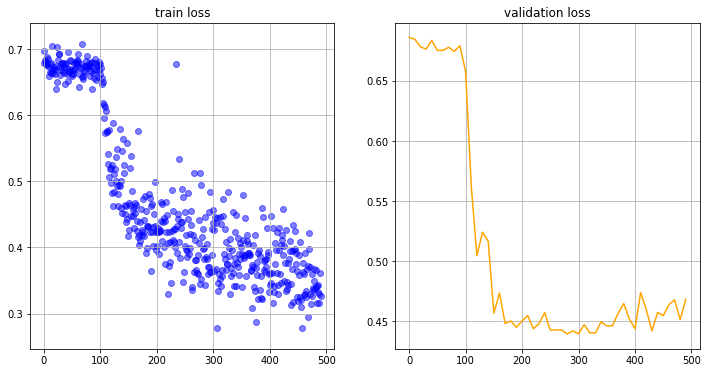

In [10]:
optimizer = tf.optimizers.Adam()
best_weights = training(model,optimizer)        
model.set_weights(best_weights) #restore from the best iteration

In [11]:
print(evaluate(model,lines_test,y_test,64))

0.7292863002461034


##### word embeddings + char -level word embeddings

Aside from word embeddings, use convolutional layers to capture char-level information, a Highway network is then used to concatenate the results from the two parts.(details in encoders.py) No pre-trained embeddings is used in this method.

In [14]:
#a char-index table
text2mat_char = Text2mat(lines,mode='char',low_count_threshold=100)

emb_size, hid_size = 128, 64
vocab_size, char_size = text2mat_word.n_tokens, text2mat_char.n_tokens
conv_kernel_sizes = [3,5,7,9]
conv_hid_size = 32

model = CombinedEncoder(vocab_size,char_size,emb_size,emb_size,hid_size,hid_size,
                 conv_kernel_sizes,conv_hid_size)

In [15]:
def compute_loss(model,batch_lines,batch_label):
    logits = model.get_logits(batch_lines,text2mat_word,text2mat_char)
    labels = tf.cast(tf.reshape(batch_label,[-1,1]),logits.dtype)
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels,logits))

def evaluate(model,lines_to_eva,y,batch_size=256):
    pred = np.array([])
    for i in range(0,len(lines_to_eva),batch_size):
        batch_line = lines_to_eva[i:i+batch_size]
        X_w, X_c = text2mat_word.to_matrix(batch_line), text2mat_char.to_matrix(batch_line)
        pred_i = np.rint(tf.math.sigmoid(model(X_w,X_c))).astype('int').reshape((-1,))
        pred = np.concatenate([pred,pred_i])
    return f1_score(y,pred)

##### shape verification

In [16]:
dummy_input_w = text2mat_word.to_matrix(lines[:3])
dummy_input_c = text2mat_char.to_matrix(lines[:3])
print(f'input word:{dummy_input_w.shape}')
print(f'input char:{dummy_input_c.shape}')

word_encoder_output = model.w_encoder(dummy_input_w)
print(f'word encoder:{word_encoder_output.shape}')

char_encoder_output = model.c_encoder(dummy_input_c)
print(f'word encoder:{char_encoder_output.shape}')

total_output = model(dummy_input_w,dummy_input_c)
print(f'final output:{total_output.shape}')

input word:(3, 25)
input char:(3, 133)
word encoder:(3, 64)
word encoder:(3, 64)
final output:(3, 1)


##### training

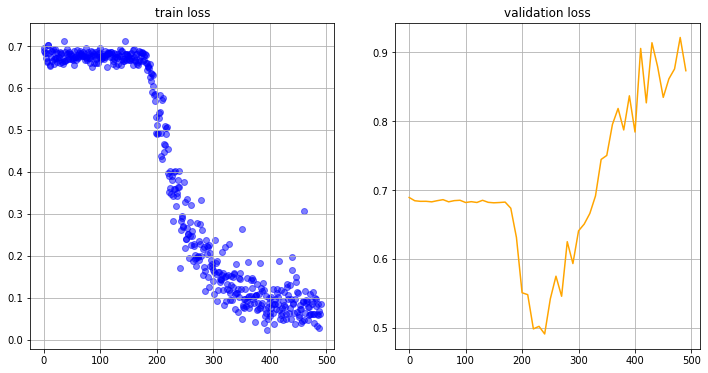

In [17]:
optimizer = tf.optimizers.Adam()
best_weights = training(model,optimizer)        
model.set_weights(best_weights) #restore from the best iteration

In [18]:
print(evaluate(model,lines_test,y_test,64))

0.7292905271502179


##### summary
(in F1-score)

- baseline bayes model: 0.711
- pre-trianed embeddings + GRU: 0.729
- wordRNN + charRNN:0.729
- fine-tuning with BERT: 0.778

##### Analyze

- due to the existence of a large amount of words that are unregularly spelled in the corpus, a char-level network is added, but it does perform as well as expected;

- BERT's wordpiece tokenizer adapts well to the scenario, yet the performance of fine-tuning is limited due to the size of corpus. 